# Imports

In [1]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from PIL import Image
from pycocotools.coco import COCO
from skimage import io, transform
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import timm

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Init Paths

In [2]:
TRAIN_IMAGES_DIRECTORY = "./train/images"
TRAIN_LABELS_DIRECTORY = "./train/labels"
TRAIN_ANNOT_DIRECTORY = "./train/annotation.json"

VAL_IMAGES_DIRECTORY = "./val/images"
VAL_LABELS_DIRECTORY = "./val/labels"
VAL_ANNOT_DIRECTORY = "./val/annotation.json"

TEST_IMAGES_DIRECTORY = "./test_images"

checkpoint_path = "./checkpoints"

if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)

---
# Training

## Dataset

In [3]:
def is_on_border(mask, border_width):
    return not np.any(mask[border_width:-border_width, border_width:-border_width])

class MappingChallengeDataset(Dataset):
    def __init__(self, img_dir, annotation_file, transform=None):
        self.coco = COCO(annotation_file)
        self.img_dir = img_dir
        self.transform = transform
        self.image_ids = self.coco.getImgIds()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        image = Image.open(img_path).convert("RGB")

        # Charger les annotations et créer le masque de segmentation
        ann_ids = self.coco.getAnnIds(imgIds=img_info['id'])
        anns = self.coco.loadAnns(ann_ids)
        global_mask = np.zeros((img_info['height'], img_info['width']))
        
        for ann in anns:
            temp_mask = self.coco.annToMask(ann) * ann['category_id']
            
            if not is_on_border(temp_mask, border_width=2):
                global_mask = np.maximum(temp_mask, global_mask)

        # Convertir en array et ajuster les valeurs
        mask = np.where(global_mask == 100, 255, global_mask)
        mask = Image.fromarray(mask).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image.to(device), mask.to(device)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [4]:
training_dataset = MappingChallengeDataset(img_dir=TRAIN_IMAGES_DIRECTORY, annotation_file=TRAIN_ANNOT_DIRECTORY, transform=transform)

full_dataset_size = len(training_dataset)

train_size = int(0.7 * full_dataset_size)
validation_size = full_dataset_size - train_size

train_indices = list(range(0, train_size))
validation_indices = list(range(train_size, full_dataset_size))

# Création des objets Subset pour l'entraînement et la validation
train_subset = Subset(training_dataset, train_indices)
validation_subset = Subset(training_dataset, validation_indices)

# Création des DataLoaders pour l'entraînement et la validation
train_loader = DataLoader(train_subset, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_subset, batch_size=8, shuffle=False)

loading annotations into memory...
Done (t=21.69s)
creating index...
index created!


In [5]:
test_dataset = MappingChallengeDataset(img_dir=VAL_IMAGES_DIRECTORY, annotation_file=VAL_ANNOT_DIRECTORY, transform=transform)

test_full_dataset_size = len(test_dataset)

test_size = 1000

test_indices = list(range(test_size))

test_subset = Subset(test_dataset, test_indices)

test_loader = DataLoader(test_subset, batch_size=8, shuffle=False)

loading annotations into memory...
Done (t=5.54s)
creating index...
index created!


Outputs shape: torch.Size([8, 3, 256, 256])
Labels shape: torch.Size([8, 1, 256, 256])
Outputs type: torch.float32
Labels type: torch.float32


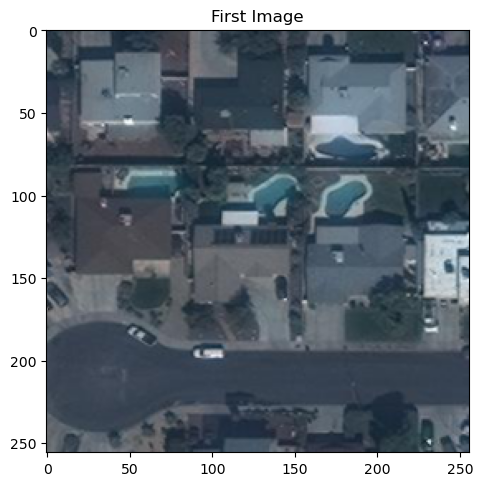

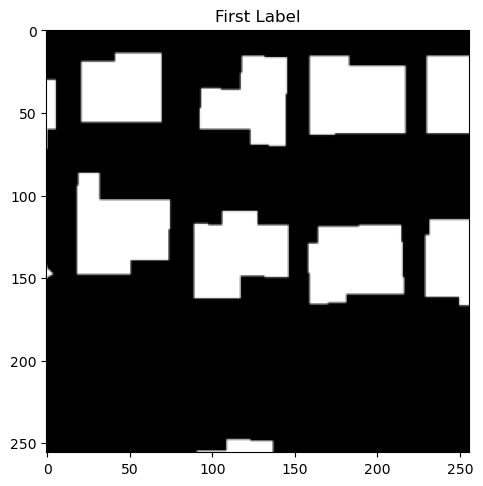

In [6]:
# Get one batch of data
for outputs, labels in train_loader:
    print("Outputs shape:", outputs.shape)
    print("Labels shape:", labels.shape)
    print("Outputs type:", outputs.dtype)
    print("Labels type:", labels.dtype)

    # Select the first image and label from the batch
    first_image = outputs[0]
    first_label = labels[0]

    # Convert them to numpy arrays for visualization
    # Adjust the dimensions and scale if necessary
    first_image_np = first_image.permute(1, 2, 0).cpu().numpy()
    first_label_np = first_label.squeeze().cpu().numpy()  # Assuming label is a single-channel image

    # Display the image and label
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(first_image_np, cmap='gray')
    plt.title('First Image')
    plt.show()
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 2)
    plt.imshow(first_label_np, cmap='gray')
    plt.title('First Label')

    plt.show()

    break  # Exit after the first iteration


## Equilibrage des classes

In [7]:
nombre_total_pixels_positifs = torch.tensor(3886232963, dtype=torch.int64)
nombre_total_pixels_negatifs = torch.tensor(14103564355, dtype=torch.int64)
#3.6291091442108154

pos_weight = nombre_total_pixels_negatifs.float() / nombre_total_pixels_positifs.float()  # Conversion en float pour division
pos_weight = torch.tensor([pos_weight.item()]).to(device)

In [8]:
#nombre_total_pixels_positifs = 0
#nombre_total_pixels_negatifs = 0

#for _, masks in train_loader:
#    nombre_total_pixels_positifs += torch.sum(masks == 1)  # Compter les pixels de bâtiments (classe 1)
#    nombre_total_pixels_negatifs += torch.sum(masks == 0)  # Compter les pixels de fond (classe 0)


#pos_weight = nombre_total_pixels_negatifs.float() / nombre_total_pixels_positifs.float()  # Conversion en float pour division
#pos_weight = torch.tensor([pos_weight.item()]).to(device)

In [9]:
print(f'nombre_total_pixels_positifs:    {nombre_total_pixels_positifs.cpu().numpy()}')
print(f'nombre_total_pixels_negatifs:    {nombre_total_pixels_negatifs.cpu().numpy()}')
print(f'                  pos_weight:    {pos_weight.cpu().numpy()[0]}')

nombre_total_pixels_positifs:    3886232963
nombre_total_pixels_negatifs:    14103564355
                  pos_weight:    3.6291091442108154


# Model

In [10]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)

class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlock, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)

class UNetResNet(nn.Module):

    def __init__(self, encoder_depth, num_classes, num_filters=32, dropout_2d=0.2,
                 pretrained=True, is_deconv=False):
        super().__init__()
        self.num_classes = num_classes
        self.dropout_2d = dropout_2d

        if encoder_depth == 34:
            self.encoder = torchvision.models.resnet34(pretrained=pretrained)
            bottom_channel_nr = 512
        elif encoder_depth == 101:
            self.encoder = torchvision.models.resnet101(pretrained=pretrained)
            bottom_channel_nr = 2048
        elif encoder_depth == 152:
            self.encoder = torchvision.models.resnet152(pretrained=pretrained)
            bottom_channel_nr = 2048
        else:
            raise NotImplementedError('only 34, 101, 152 version of Resnet are implemented')

        self.pool = nn.MaxPool2d(2, 2)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder.conv1,
                                   self.encoder.bn1,
                                   self.encoder.relu,
                                   self.pool)

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.conv5 = self.encoder.layer4

        self.center = DecoderBlock(bottom_channel_nr, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec5 = DecoderBlock(bottom_channel_nr + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlock(bottom_channel_nr // 2 + num_filters * 8, num_filters * 8 * 2, num_filters * 8,
                                   is_deconv)
        self.dec3 = DecoderBlock(bottom_channel_nr // 4 + num_filters * 8, num_filters * 4 * 2, num_filters * 2,
                                   is_deconv)
        self.dec2 = DecoderBlock(bottom_channel_nr // 8 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2,
                                   is_deconv)
        self.dec1 = DecoderBlock(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        pool = self.pool(conv5)
        center = self.center(pool)

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(dec2)
        dec0 = self.dec0(dec1)

        return self.final(F.dropout2d(dec0, p=self.dropout_2d))

## Train Model

In [11]:
def iou_loss(outputs, labels, smooth=1e-6):
    # Applatissement des prédictions et des vérités terrain
    outputs = outputs.view(-1)
    labels = labels.view(-1)
    
    # Calcul de l'intersection et de l'union
    intersection = (outputs * labels).sum()
    total = (outputs + labels).sum()
    union = total - intersection 
    
    # Calcul de IoU
    IoU = (intersection + smooth) / (union + smooth)
    
    # La perte est 1 - IoU pour la minimiser
    return 1 - IoU

def train_model(model, train_loader, save_path, epochs=10, lr=0.001):
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    #criterion = iou_loss
    #criterion = torch.nn.MSELoss()
    #criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    criterion = torch.nn.BCEWithLogitsLoss()

    os.makedirs(save_path, exist_ok=True)

    for epoch in range(epochs):
        # Entraînement
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for batch_idx, (images, masks) in progress_bar:
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()

            predicted = outputs > 0.5
            correct_predictions += (predicted == masks).sum().item()
            total_predictions += masks.numel()

            loss.backward()
            optimizer.step()

            progress_bar.set_postfix({"loss": running_loss / (batch_idx + 1)})

        scheduler.step()

        epoch_loss = running_loss/len(train_loader)
        epoch_accuracy = correct_predictions / total_predictions

        tqdm.write(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss}, Training Accuracy: {epoch_accuracy}")

        # Validation
        model.eval()
        validation_loss = 0.0
        correct_val_predictions = 0
        total_val_predictions = 0
        with torch.no_grad():
            for images, masks in validation_loader:
                outputs = model(images)
                loss = criterion(outputs, masks)
                validation_loss += loss.item()

                predicted = outputs > 0.5
                correct_val_predictions += (predicted == masks).sum().item()
                total_val_predictions += masks.numel()

        val_loss = validation_loss/len(validation_loader)
        val_accuracy = correct_val_predictions / total_val_predictions

        tqdm.write(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
        
        # Enregistrer la loss et l'accuracy dans TensorBoard
        writer.add_scalar('Loss/train', epoch_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/train', epoch_accuracy, epoch)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch)

        # Sauvegarde du modèle
        torch.save(model.state_dict(), os.path.join(save_path, f'model_epoch_{epoch+1}.pth'))


## Init Train 

In [12]:
model = UNetResNet(encoder_depth=152, num_classes=1)
model.to(device)

C:\Users\mathi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mathi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


UNetResNet(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [12]:
train_id = 'test_152_Full_10_BCE_pretrained'
writer = SummaryWriter(f'runs/{train_id}')
train_model(model, train_loader, epochs=10, save_path=f'model_checkpoints/{train_id}')

Epoch 1/10, Training Loss: 0.15185372308048264, Training Accuracy: 0.9300517535655877
Epoch 1/10, Validation Loss: 0.10901925090054973, Validation Accuracy: 0.9436346288943072


Epoch 2/10, Training Loss: 0.10720844907777484, Training Accuracy: 0.9441579486537622
Epoch 2/10, Validation Loss: 0.0990277308398167, Validation Accuracy: 0.9488097641599765


Epoch 3/10, Training Loss: 0.09771903943935431, Training Accuracy: 0.9477891951599515
Epoch 3/10, Validation Loss: 0.09311711341942347, Validation Accuracy: 0.9480579332241373


Epoch 4/10, Training Loss: 0.09310699241323431, Training Accuracy: 0.9495074486525994
Epoch 4/10, Validation Loss: 0.0964598204218004, Validation Accuracy: 0.9491030051017137


Epoch 5/10, Training Loss: 0.08880528394286778, Training Accuracy: 0.9510616532748729
Epoch 5/10, Validation Loss: 0.08697257353552676, Validation Accuracy: 0.9523964524729109


Epoch 6/10, Training Loss: 0.08543758156343327, Training Accuracy: 0.9521918660147584
Epoch 6/10, Validation Loss: 0.08568523633385808, Validation Accuracy: 0.9514095371210511


Epoch 7/10, Training Loss: 0.08218879462199871, Training Accuracy: 0.9532825677013117
Epoch 7/10, Validation Loss: 0.08638719667356438, Validation Accuracy: 0.952541352178923


Epoch 8/10, Training Loss: 0.08044014854924197, Training Accuracy: 0.9538812692942875
Epoch 8/10, Validation Loss: 0.08152584698848075, Validation Accuracy: 0.9534416875858143


Epoch 9/10, Training Loss: 0.07762833259485657, Training Accuracy: 0.9548091604050146
Epoch 9/10, Validation Loss: 0.08090784924110471, Validation Accuracy: 0.9540607177963375


Epoch 10/10, Training Loss: 0.07598118536210693, Training Accuracy: 0.9553714452057588
Epoch 10/10, Validation Loss: 0.08119456340168889, Validation Accuracy: 0.9531992746101797


In [13]:
%reload_ext tensorboard
%tensorboard --logdir runs --port 6010

Reusing TensorBoard on port 6010 (pid 2496), started 23:00:42 ago. (Use '!kill 2496' to kill it.)

# Test

## Loading saved Model

In [13]:
def load_model(model_class, save_path, epoch, **model_kwargs):
    """
    Load a PyTorch model from a saved state dictionary.

    Args:
    model_class: The class of the model (e.g., MyModel).
    save_path: The path where the model is saved.
    epoch: The epoch number of the saved model.
    model_kwargs: Additional keyword arguments to pass to the model class constructor.

    Returns:
    A PyTorch model loaded with the saved state dictionary.
    """
    import torch
    import os

    # Create an instance of your model with additional arguments if any
    model = model_class(**model_kwargs)

    # Load the saved state dictionary
    model_path = os.path.join(save_path, f'model_epoch_{epoch}.pth')
    model.load_state_dict(torch.load(model_path))

    return model

In [24]:
model = load_model(
    model_class=UNetResNet, 
    save_path='model_checkpoints/test_152_Full_10_BCE_pretrained', 
    epoch=10,
    encoder_depth=152, 
    num_classes=1
)
model.to(device)

UNetResNet(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [25]:
import matplotlib.pyplot as plt

def visualize_predictions(model, data_loader, threshold):
    model.eval()
    images, masks = next(iter(data_loader))
    with torch.no_grad():
        outputs = model(images)
        outputs = (torch.sigmoid(outputs) > threshold) * 255

    # Prendre la première image du batch pour l'exemple
    img = images[0].permute(1, 2, 0).cpu().numpy()  # Réorganiser les canaux pour affichage et convertir en numpy
    pred_mask = outputs[0].cpu().numpy()  # Appliquer sigmoid, arrondir et convertir en numpy
    print(pred_mask.sum())
    gt_mask = masks[0].cpu().numpy()

    # Redimensionner si nécessaire pour matplotlib
    pred_mask = pred_mask.squeeze()  # Enlever le canal s'il est seul
    gt_mask = gt_mask.squeeze()  # Enlever le canal s'il est seul

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img)
    axs[0].set_title('Original Image')
    axs[1].imshow(pred_mask, cmap='gray')
    axs[1].set_title('Predicted Mask')
    axs[2].imshow(gt_mask, cmap='gray')
    axs[2].set_title('Ground Truth Mask')
    plt.show()


In [16]:
from sklearn.metrics import f1_score
model.eval()
images, masks = next(iter(train_loader))
with torch.no_grad():
    outputs = model(images)
    probabilities = torch.sigmoid(outputs).cpu().numpy()
    true_labels = masks.cpu().numpy().astype(np.bool_)

    # Calculer les scores F1 pour une gamme de seuils
    thresholds = np.linspace(0, 1, num=100)
    f1_scores = [f1_score(true_labels.flatten(), (probabilities.flatten() > threshold).astype(np.bool_)) for threshold in thresholds]

    # Trouver le seuil avec le meilleur score F1
    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]
    best_f1_score = f1_scores[best_threshold_index]

    print(f"Best Threshold: {best_threshold}")
    print(f"Best F1 Score: {best_f1_score}")


Best Threshold: 0.0
Best F1 Score: 0.34736930033459995


In [26]:
threshold = 0.5

10603920


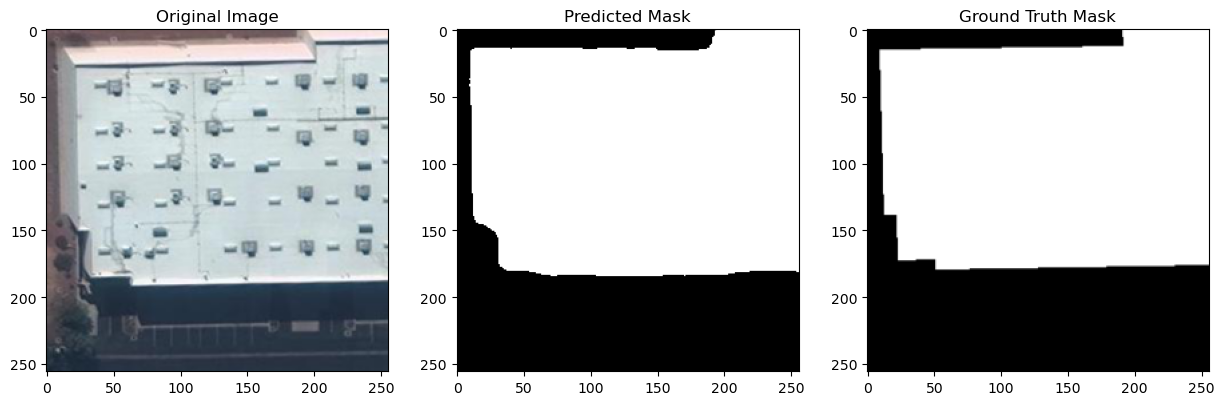

2304690


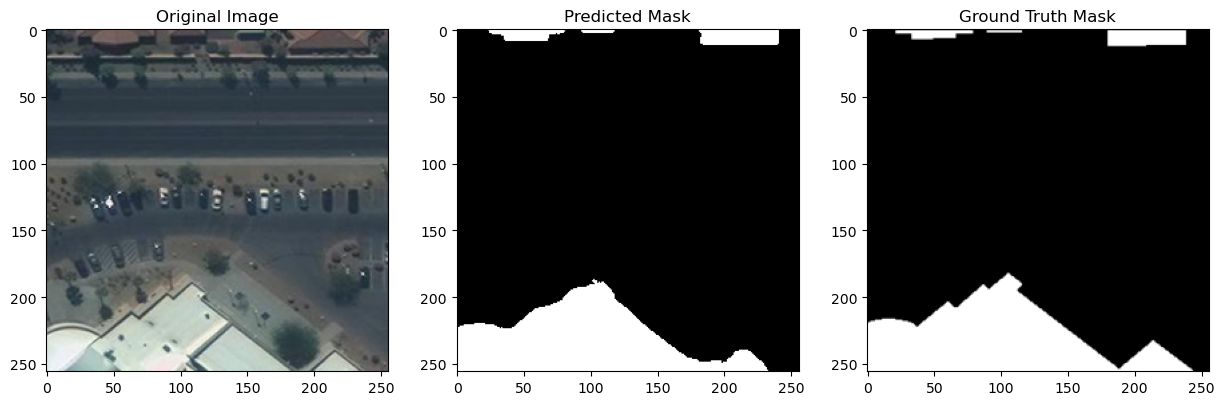

1132455


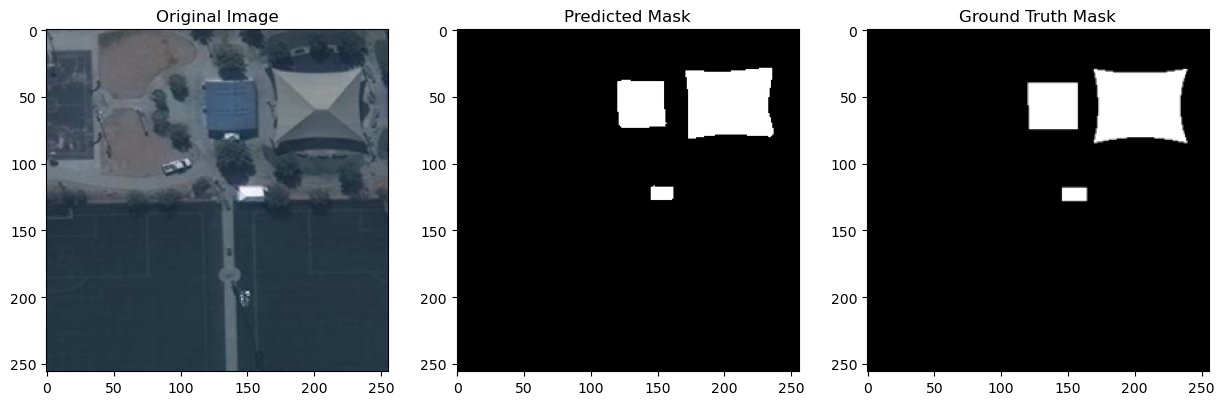

1172745


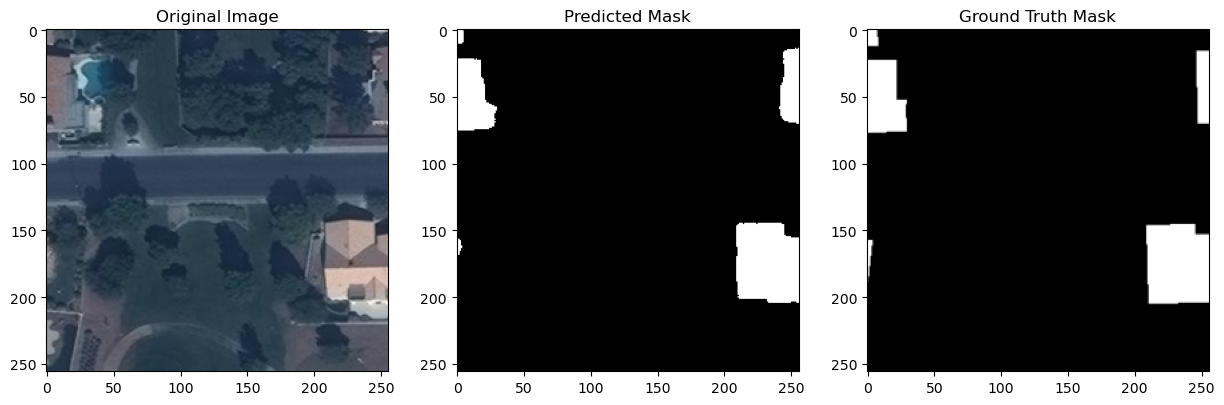

4903905


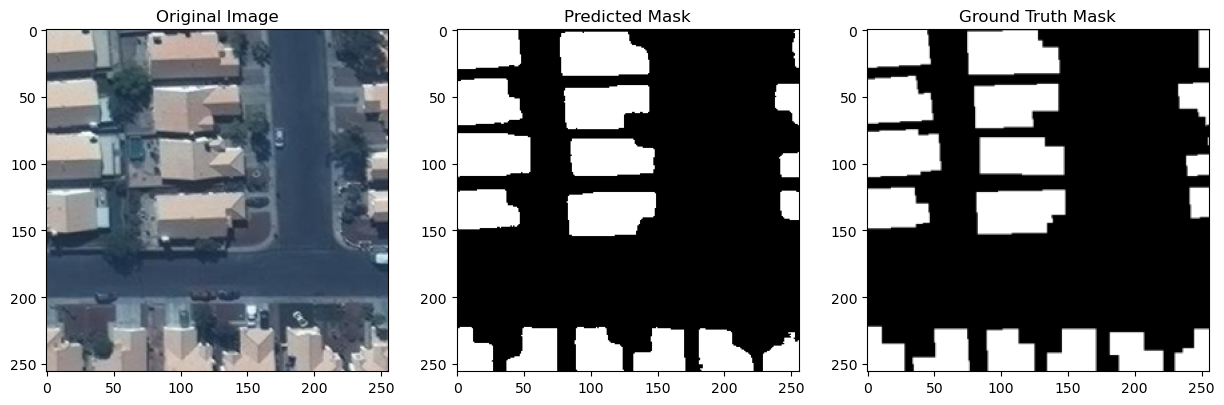

685950


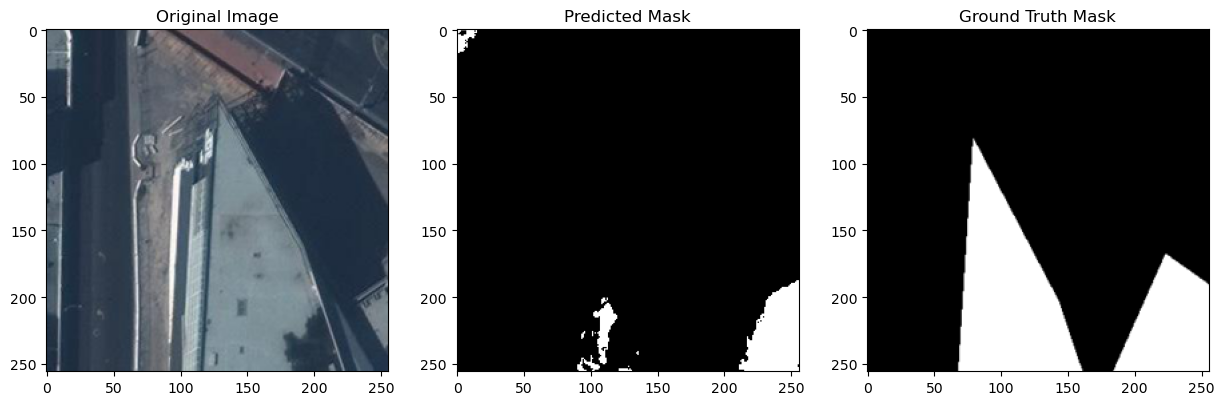

5433030


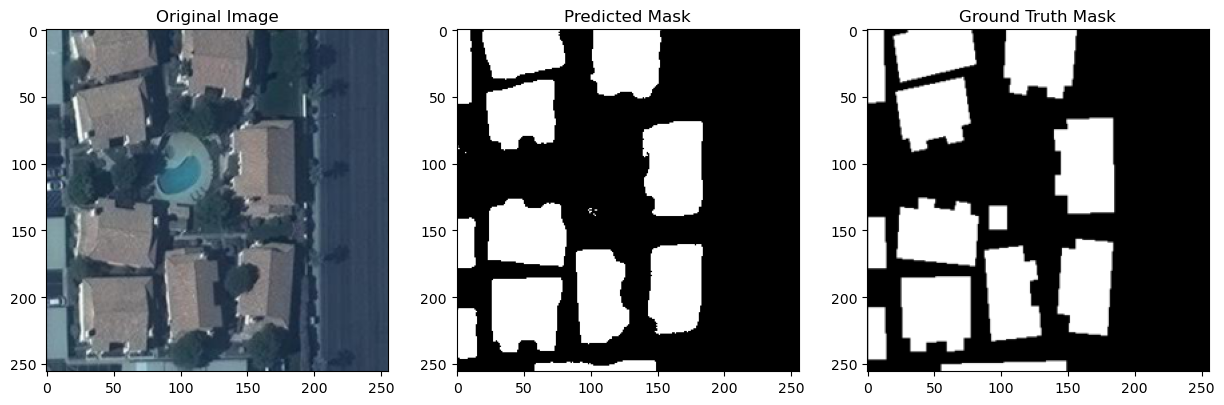

4654260


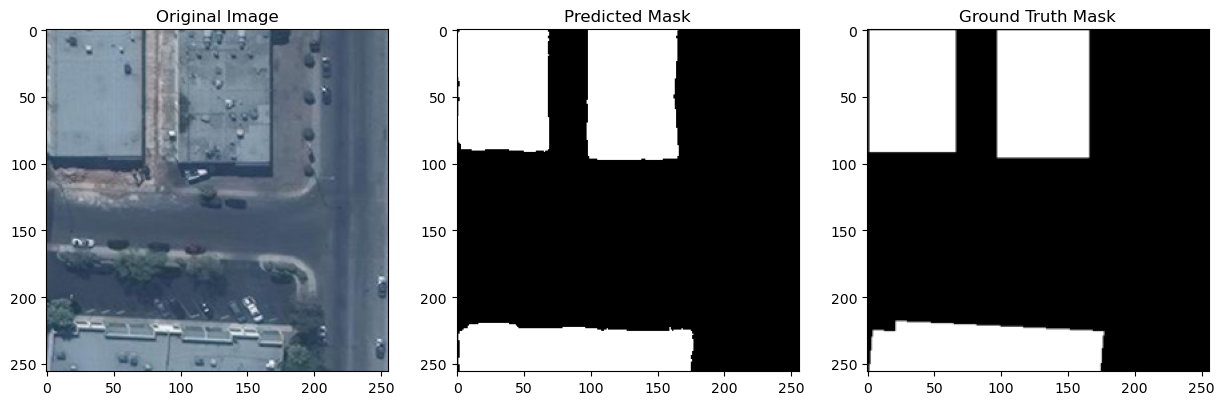

5514375


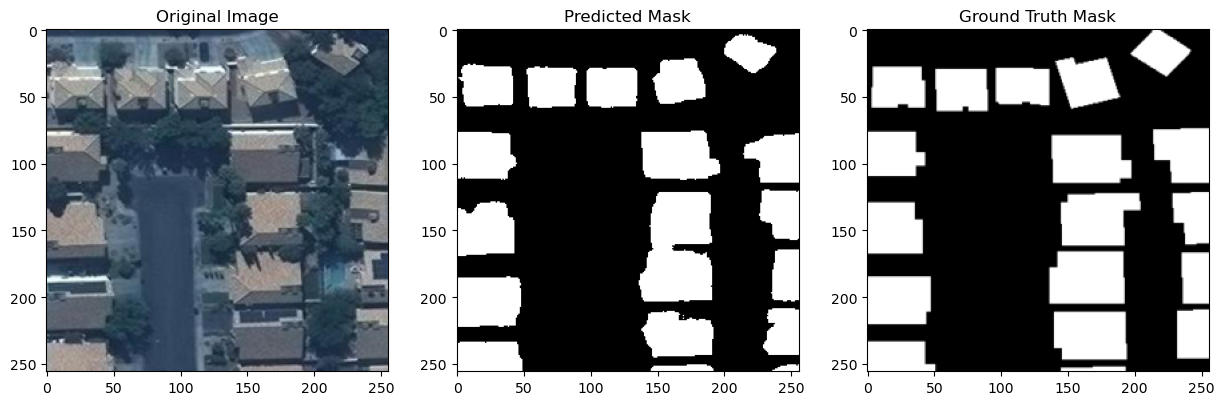

4609380


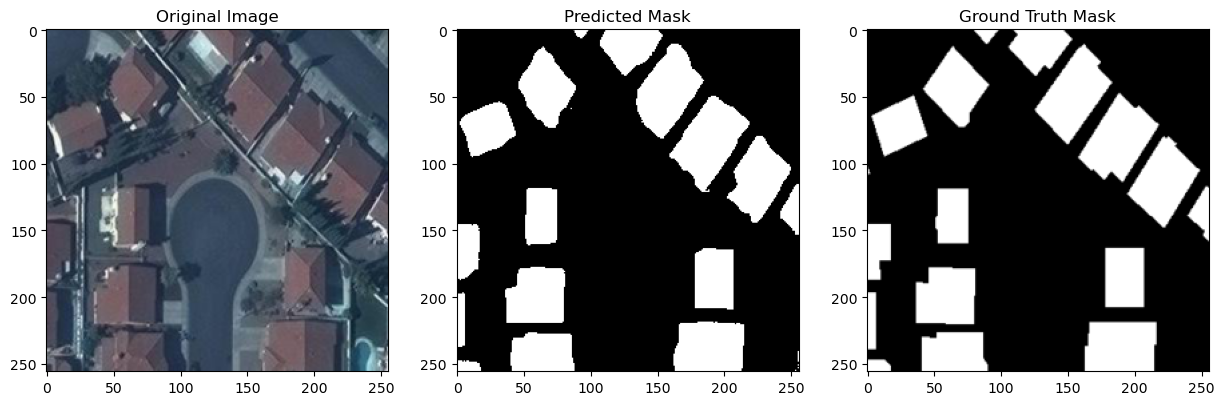

In [27]:
for i in range(10):visualize_predictions(model, train_loader, threshold)

In [19]:
def test_model(model, test_loader):
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, masks in test_loader:
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss}")
    return avg_loss


In [20]:
test_model(model, train_loader)

Test Loss: 0.7186740920657203


0.7186740920657203

---
# Polygonisation

## Methode 1

In [28]:
def post_process_mask(mask, kernel_size=(5, 5)):
    """ Cleans the mask using morphological operations. """
    kernel = np.ones(kernel_size, np.uint8)
    closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
    return opening

def mask_to_filled_polygons(mask):
    """ Converts a mask to a set of filled polygons using approxPolyDP. """
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    filled_polygons = np.zeros_like(mask)
    for contour in contours:
        # Approximate contour and then fill it in the mask
        polygon = cv2.approxPolyDP(contour, 2, True)
        cv2.fillPoly(filled_polygons, [polygon], color=(255))
    return filled_polygons

def calculate_iou(mask1, mask2):
    """ Calculate Intersection over Union (IoU) between two binary masks. """
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def visualize_predictions_with_polygons(model, data_loader, threshold):
    """ Visualizes predictions with polygonized masks. """
    model.eval()
    images, masks = next(iter(data_loader))
    with torch.no_grad():
        outputs = model(images)
        outputs = (torch.sigmoid(outputs) > threshold).type(torch.uint8)

    # Process the first image of the batch for example
    img = images[0].permute(1, 2, 0).cpu().numpy()  # Rearrange channels for display and convert to numpy
    pred_mask = outputs[0].cpu().numpy().squeeze() * 255  # Apply sigmoid, round, and convert to numpy
    gt_mask = masks[0].cpu().numpy().squeeze()
    
    # Post-process and polygonize the predicted mask
    post_processed_mask = post_process_mask(pred_mask)
    filled_polygons = mask_to_filled_polygons(post_processed_mask)

    # Calculate IoU
    iou = calculate_iou(filled_polygons, gt_mask)

    # Visualization
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(img)
    axs[0].set_title('Original Image')
    axs[1].imshow(pred_mask, cmap='gray')
    axs[1].set_title('Predicted Mask')
    axs[2].imshow(filled_polygons, cmap='gray')
    axs[2].set_title('Filled Polygonized Predictions')
    axs[3].imshow(gt_mask, cmap='gray')
    axs[3].set_title('Ground Truth Mask')
    
    for ax in axs:
        ax.axis('off')  # Hide axes
    plt.show()

    print(f"IoU between Polygonized Predictions and Ground Truth Mask: {iou:.2f}")

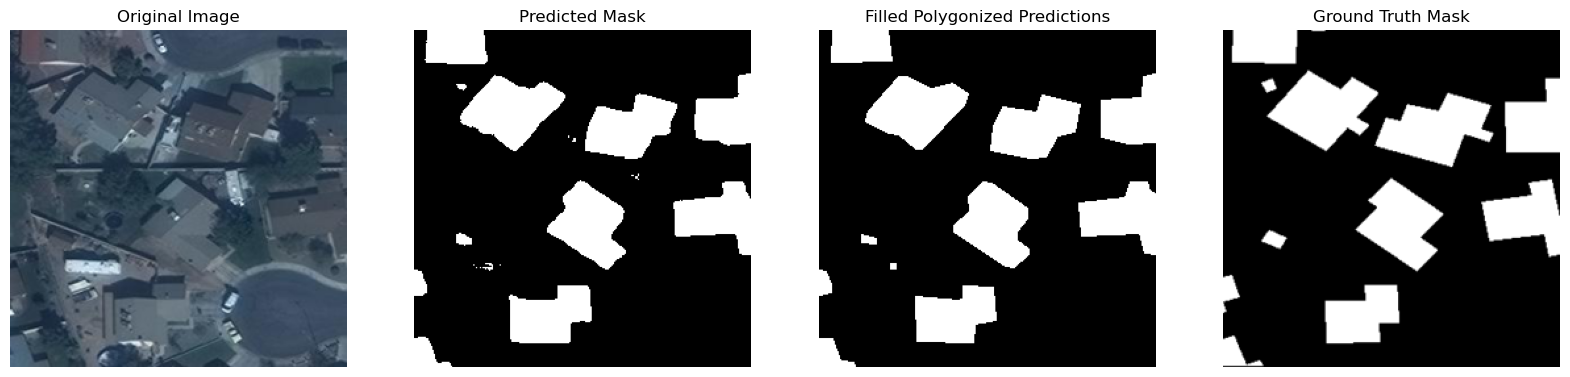

IoU between Polygonized Predictions and Ground Truth Mask: 0.81


In [116]:
visualize_predictions_with_polygons(model, train_loader, threshold)

---

# Evaluation

## Semantic Segmentation

In [41]:
def calculate_iou(mask1, mask2):
    """ Calculate Intersection over Union (IoU) between two binary masks. """
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    union_sum = np.sum(union)

    # Gérer le cas où l'union est zéro pour éviter la division par zéro
    if union_sum == 0:
        return float('nan')  # Retourner NaN si aucun pixel n'est en commun

    iou = np.sum(intersection) / union_sum
    return iou

def enforce_binary_masks(masks):
    """Ensure that masks only contain binary values 0 or 1."""
    return (masks > 0).astype(np.uint8)

def calculate_f1_score(true_masks_flat, pred_masks_flat):
    """Calculate the F1 score from flattened binary masks."""
    # Check for non-binary values
    assert set(np.unique(true_masks_flat)).issubset({0, 1}), "Non-binary values found in true masks"
    assert set(np.unique(pred_masks_flat)).issubset({0, 1}), "Non-binary values found in predicted masks"
    return f1_score(true_masks_flat, pred_masks_flat, average='macro')

def calculate_confusion_matrix(true_masks_flat, pred_masks_flat):
    """Calculate the confusion matrix from flattened binary masks."""
    return confusion_matrix(true_masks_flat, pred_masks_flat)

def evaluate_model(model, test_loader, is_polygonisation=False):
    """Evaluate the model for IoU, F1 score, and confusion matrix."""
    model.eval()
    total_iou = 0.0
    count = 0
    true_masks_list = []
    pred_masks_list = []

    with torch.no_grad():
        for images, true_masks in tqdm(test_loader, desc="Evaluating"):
            predictions = model(images)
            predictions = torch.sigmoid(predictions)
            predictions = (predictions > 0.5).type(torch.uint8)

            predictions_np = predictions.cpu().numpy()
            true_masks_np = true_masks.cpu().numpy()

            for i in range(images.size(0)):
                pred_mask = predictions_np[i].squeeze()
                gt_mask = true_masks_np[i].squeeze()

                if is_polygonisation:
                    # Assuming post_process_mask and mask_to_filled_polygons are defined elsewhere
                    pred_mask = post_process_mask(pred_mask)
                    pred_mask = mask_to_filled_polygons(pred_mask)

                pred_mask = enforce_binary_masks(pred_mask)
                gt_mask = enforce_binary_masks(gt_mask)

                true_masks_list.append(gt_mask.flatten())
                pred_masks_list.append(pred_mask.flatten())

                iou = calculate_iou(pred_mask, gt_mask)
                if not np.isnan(iou):
                    total_iou += iou
                    count += 1

    # Compute global metrics outside the loop
    all_true_masks = np.concatenate(true_masks_list)
    all_pred_masks = np.concatenate(pred_masks_list)
    
    average_iou = total_iou / count if count > 0 else float('nan')
    global_f1_score = calculate_f1_score(all_true_masks, all_pred_masks)
    global_conf_matrix = calculate_confusion_matrix(all_true_masks, all_pred_masks)
    
    return average_iou, global_f1_score, global_conf_matrix

# Utilisation of the evaluation function for ModelMask
average_iou, global_f1_score, global_conf_matrix = evaluate_model(model, test_loader)

# Utilisation of the evaluation function with is_polygonisation=True for Polygonisation
average_iou_poly, global_f1_score_poly, global_conf_matrix_poly = evaluate_model(model, test_loader, is_polygonisation=True)

Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.42it/s]


In [42]:
average_iou, global_f1_score, global_conf_matrix

(0.8250973839290116,
 0.9503162402052177,
 array([[49451294,   585199],
        [ 1706902, 13792605]], dtype=int64))

In [43]:
average_iou_poly, global_f1_score_poly, global_conf_matrix_poly

(0.8150953783474902,
 0.9472740002171809,
 array([[49472757,   563736],
        [ 1858747, 13640760]], dtype=int64))

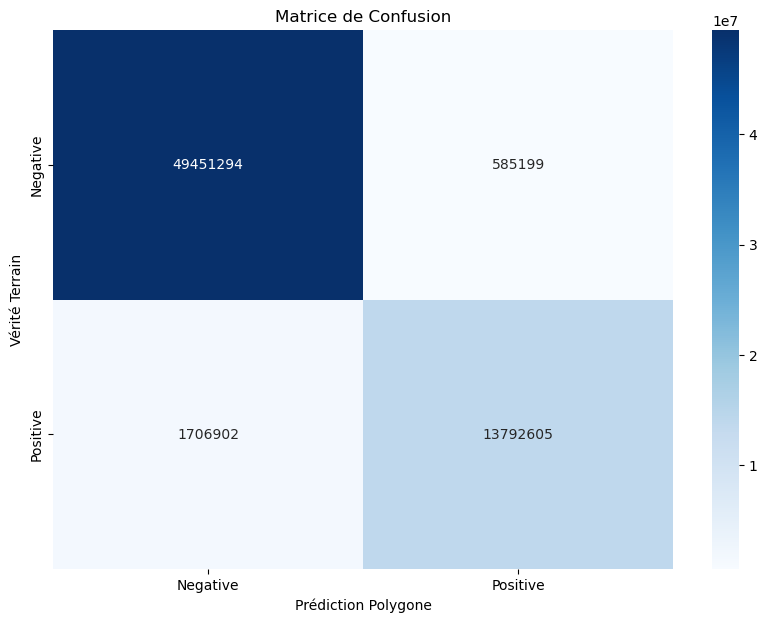

In [46]:
import seaborn as sns

# Tes données de matrice de confusion
conf_matrix = global_conf_matrix

# Crée une heatmap avec seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])

plt.title('Matrice de Confusion')
plt.ylabel('Vérité Terrain')
plt.xlabel('Prédiction Polygone')
plt.show()